In [1]:
import trecs
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

N.B. This notebook is tested for the `main` branch of `t-recs` as of 1/20/2021.

In [2]:
# generate user vector
generator = np.random.default_rng()
# parameters
num_users = 100
num_items = 200
num_attrs = 20
num_sims = 10

user_params = np.random.dirichlet(np.ones(num_attrs), size=num_sims) * 10
item_params = np.random.dirichlet(np.ones(num_attrs) * 100, size=num_sims) * 0.1
# do conversion from paper to fiure out the utility percentage visible to users
mu_n = 0.98
sigma = 1e-5
alpha = ((1-mu_n) / (sigma**2) - (1/mu_n)) * mu_n**2
beta = alpha * (1/mu_n - 1)
# each element in users is the users vector in one simulation
users = []
items = []
true_utilities = []
known_util_perc = []


for sim_index in range(num_sims):
    users.append(np.random.dirichlet(user_params[sim_index, :], size=num_users)) # 100 users
    items.append(np.random.dirichlet(item_params[sim_index, :], size=num_items)) # 200 items
    true_utilities.append(users[-1] @ items[-1].T)
    known_util_perc.append(np.random.beta(alpha, beta, size=(num_users, num_items)))
    
# print shape
print(users[0].shape) # we should see 100 users with 20 attributes
print(items[0].shape) # we should see 1000 items with 20 attributes

(100, 20)
(200, 20)


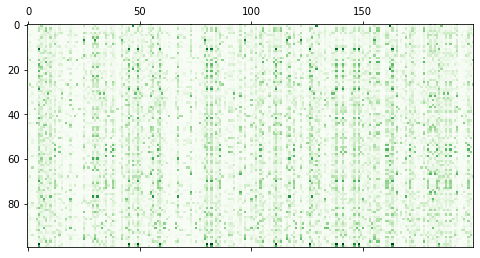

In [3]:
plt.matshow(true_utilities[0], cmap='Greens')

# this seems reasonably sparse and matches the picture in the Chaney paper! let's proceed

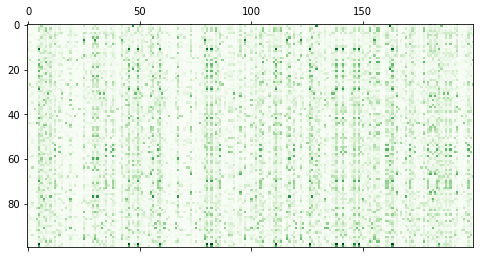

In [4]:
plt.matshow(true_utilities[0] * known_util_perc[0], cmap='Greens')

In [6]:
# try running simulation 
from trecs.models import ContentFiltering, PopularityRecommender
from trecs.components import Users, Items
from trecs.metrics import HomogeneityMeasurement, JaccardSimilarity
from trecs.matrix_ops import normalize_matrix

In [7]:
# basically just recommends items based on the estimates of user preferences!
# this will form the basis of our "ideal" recommender
class IdealRecommender(ContentFiltering):
    def _update_internal_state(self, interactions):
        # do not change users_hat! 
        pass

In [8]:
# random recommender - randomly update users at every step
class RandomRecommender(ContentFiltering):
    def _update_internal_state(self, interactions):
        # do not change users_hat! 
        self.users_hat[:, :] = np.random.randint(2, size=self.users_hat.shape)

In [9]:
# run 10 trials and average over each

ideal_recs = [] # store models
cfs = []
pops = []
randoms = []

startup_iters = 50
sim_iters = 950

for i in range(num_sims):
    true_prefs = users[i] # underlying true preferences
    true_scores = true_utilities[i]
    noisy_scores = known_util_perc[i] * true_utilities[i]

    # generate random pairs for evaluating jaccard similarity
    pairs = [np.random.choice(num_users, 2, replace=False) for _ in range(500)]

    u = Users(actual_user_scores = noisy_scores, size=(num_users, num_attrs), num_users=num_users) # each user interacts with items based on their (noisy) knowledge of their own scores
    # recommender has the ideal item representation and ideal user representation
    ideal_rec = IdealRecommender(item_representation=items[i].T, user_representation=true_prefs, actual_user_representation=u)
    ideal_rec.add_metrics(HomogeneityMeasurement(), JaccardSimilarity(pairs))
    ideal_rec.run(
        timesteps=startup_iters + sim_iters,
        train_between_steps=False, 
        random_items_per_iter=ideal_rec.num_items_per_iter, 
        vary_random_items_per_iter=True
    )
    ideal_recs.append(ideal_rec)
    
    # make sure nothing weird happened during simulation
    np.testing.assert_array_equal(ideal_rec.users_hat, true_prefs)
    np.testing.assert_array_equal(ideal_rec.items_hat, items[i].T)
    np.testing.assert_array_equal(u.actual_user_scores, noisy_scores)
    # check that actual user scores as a percentage of the true utilities
    # is the same as the known util percentages
    normalized_utility = np.dot(normalize_matrix(true_prefs, axis=1), items[i].T)
    np.testing.assert_array_almost_equal(ideal_rec.predicted_scores, normalized_utility)
    
    # normal cf model for comparison

    # model only gets item attributes, doesn't know the user preferences
    cf = ContentFiltering(item_representation=items[i].T, actual_user_representation=u)
    cf.add_metrics(HomogeneityMeasurement(), JaccardSimilarity(pairs))
    cf.startup_and_train(timesteps=startup_iters)
    
    cf.run(
        timesteps=sim_iters, 
        random_items_per_iter=cf.num_items_per_iter, 
        vary_random_items_per_iter=True
    )
    cfs.append(cf)
    
    # popularity model
    p = PopularityRecommender(actual_item_representation=items[i].T, actual_user_representation=u, num_items=num_items, num_users=num_users)
    p.add_metrics(HomogeneityMeasurement(), JaccardSimilarity(pairs))
    p.startup_and_train(timesteps=startup_iters)
    p.run(
        timesteps=sim_iters,
        random_items_per_iter=p.num_items_per_iter, 
        vary_random_items_per_iter=True
    )
    pops.append(p)
    
    # random recommender
    r = RandomRecommender(item_representation=items[i].T, actual_user_representation=u, num_items=num_items, num_users=num_users)
    r.add_metrics(HomogeneityMeasurement(), JaccardSimilarity(pairs))
    r.startup_and_train(timesteps=startup_iters)
    r.run(
        timesteps=sim_iters,
        random_items_per_iter=p.num_items_per_iter, 
        vary_random_items_per_iter=True)
    randoms.append(r)

100%|██████████| 950/950 [00:12<00:00, 73.34it/s]


In [10]:
ideal_jaccard = np.array([r.get_measurements()['jaccard_similarity'][1:] for r in ideal_recs])
cf_jaccard = np.array([r.get_measurements()['jaccard_similarity'][1:] for r in cfs])
pop_jaccard = np.array([r.get_measurements()['jaccard_similarity'][1:] for r in pops])
random_jaccard = np.array([r.get_measurements()['jaccard_similarity'][1:] for r in randoms])


# make changes relative to ideal recommender
cf_jaccard -= ideal_jaccard
pop_jaccard -= ideal_jaccard
random_jaccard -= ideal_jaccard
ideal_jaccard -= ideal_jaccard

# average across 10 trials
avg_ideal = ideal_jaccard.mean(axis=0)
avg_cf_rel = cf_jaccard.mean(axis=0)
avg_pop_rel = pop_jaccard.mean(axis=0)
avg_rand_rel = random_jaccard.mean(axis=0)

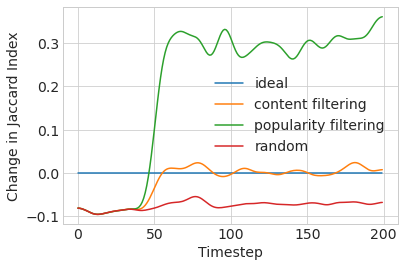

In [11]:
plt.style.use('seaborn-whitegrid')

plt.rcParams.update({'font.size': 14})
plt.plot(avg_ideal[:200], label="ideal")
plt.plot(gaussian_filter1d(np.copy(avg_cf_rel[:200]), sigma=5), label="content filtering")
plt.plot(gaussian_filter1d(np.copy(avg_pop_rel[:200]), sigma=5), label="popularity filtering")
plt.plot(gaussian_filter1d(np.copy(avg_rand_rel[:200]), sigma=5), label="random")
plt.ylabel("Change in Jaccard Index")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1)
plt.savefig('line_plot_font.pdf')

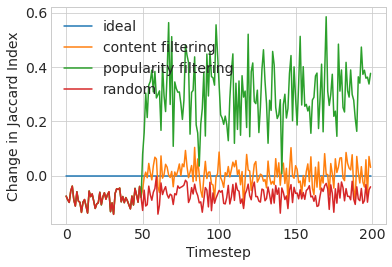

In [12]:
plt.style.use('seaborn-whitegrid')


plt.plot(avg_ideal[:200], label="ideal")
plt.plot(avg_cf_rel[:200], label="content filtering")
plt.plot(avg_pop_rel[:200], label="popularity filtering")
plt.plot(avg_rand_rel[:200], label="random")
plt.ylabel("Change in Jaccard Index")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1)
plt.savefig('line_plot.pdf')

In [14]:
ideal_homo = ideal_rec.get_measurements()['homogeneity']
cf_homo = cf.get_measurements()['homogeneity']

Text(0.5, 0, 'Iteration')

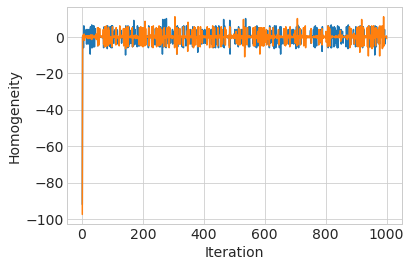

In [15]:
plt.plot(ideal_homo)
plt.plot(cf_homo)
plt.ylabel("Homogeneity")
plt.xlabel("Iteration")

In [16]:
ideal_jacc = ideal_rec.get_measurements()['jaccard_similarity']
cf_jacc = cf.get_measurements()['jaccard_similarity']
pop_jacc = p.get_measurements()['jaccard_similarity']

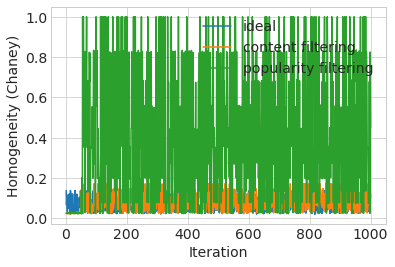

In [17]:
plt.plot(ideal_jacc, label="ideal")
plt.plot(cf_jacc, label="content filtering")
plt.plot(pop_jacc, label="popularity filtering")
plt.ylabel("Homogeneity (Chaney)")
plt.xlabel("Iteration")
plt.legend()

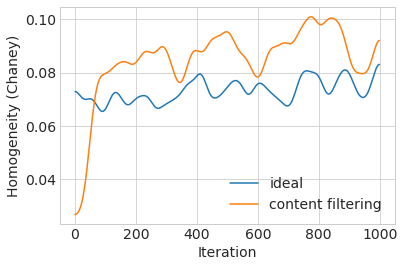

In [18]:
# smoothed version
# index from 1 b/c of initial None value

plt.plot(gaussian_filter1d(np.copy(ideal_jacc[1:]), sigma=20), label="ideal")
plt.plot(gaussian_filter1d(np.copy(cf_jacc[1:]), sigma=20), label="content filtering")
plt.ylabel("Homogeneity (Chaney)")
plt.xlabel("Iteration")
plt.legend()

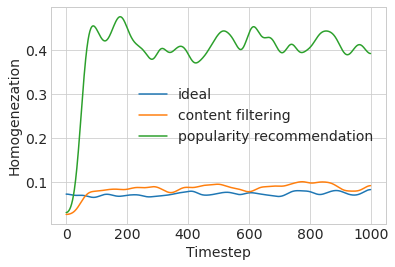

In [19]:
# smoothed version
# index from 1 b/c of initial None value
from scipy.ndimage.filters import gaussian_filter1d
plt.style.use('seaborn-whitegrid')

plt.plot(gaussian_filter1d(np.copy(ideal_jacc[1:]), sigma=20), label="ideal")
plt.plot(gaussian_filter1d(np.copy(cf_jacc[1:]), sigma=20), label="content filtering")
plt.plot(gaussian_filter1d(np.copy(pop_jacc[1:]), sigma=20), label="popularity recommendation")
plt.ylabel("Homogenezation")
plt.xlabel("Timestep")
plt.legend()